<a href="https://colab.research.google.com/github/JeremiahSalim/dog-breed-classifier-rag/blob/main/Dog_Breed_Classification_with_information_using_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Dataset Setup

###Split Dataset

In [ ]:
import os
import shutil
import random

base_dir = '/content/drive/MyDrive/Mini Project/Dog Classification/Dataset/MiniImageNet'
output_base = '/content/drive/MyDrive/Mini Project/Dog Classification/Dataset'
train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')

for split_dir in [train_dir, val_dir]:
    os.makedirs(split_dir, exist_ok=True)

random.seed(42)

# Loop over each class folder
for cls in sorted(os.listdir(base_dir)):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    total = len(images)

    if total < 600:
        print(f"⚠️ Warning: {cls} only has {total} images (needs at least 600)")
        continue

    random.shuffle(images)

    # Split 500 train, 100 val
    train_imgs = images[:500]
    val_imgs = images[500:600]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

    print(f"✅ {cls}: {len(train_imgs)} train + {len(val_imgs)} val")

print("\n Dataset split complete! Stored inside:")
print(f"  • Train → {train_dir}")
print(f"  • Val   → {val_dir}")


✅ n02089867: 500 train + 100 val
✅ n02091244: 500 train + 100 val
✅ n02091831: 500 train + 100 val
✅ n02099601: 500 train + 100 val
✅ n02101006: 500 train + 100 val
✅ n02105505: 500 train + 100 val
✅ n02108089: 500 train + 100 val
✅ n02108551: 500 train + 100 val
✅ n02108915: 500 train + 100 val
✅ n02110063: 500 train + 100 val
✅ n02110341: 500 train + 100 val
✅ n02111277: 500 train + 100 val
✅ n02113712: 500 train + 100 val

🎉 Dataset split complete! Stored inside:
  • Train → /content/drive/MyDrive/Mini Project/Dog Classification/Dataset/train
  • Val   → /content/drive/MyDrive/Mini Project/Dog Classification/Dataset/val


###Copy Image from Drive to collab local storage for faster training

In [ ]:
!cp -r "/content/drive/MyDrive/Mini Project/Dog Classification/Dataset/train" /content/train
!cp -r "/content/drive/MyDrive/Mini Project/Dog Classification/Dataset/val" /content/val

##Find Best Hyperparameter

In [ ]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner
import matplotlib.pyplot as plt

train_dir = '/content/train'
val_dir   = '/content/val'

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    interpolation='bicubic'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False,
    interpolation='bicubic'
)

def apply_resnet_preprocessing(image, label):
    image = tf.cast(image, tf.float32)
    return preprocess_input(image), label

train_ds = train_ds.map(apply_resnet_preprocessing).prefetch(AUTOTUNE)
val_ds   = val_ds.map(apply_resnet_preprocessing).prefetch(AUTOTUNE)

num_classes = train_ds.element_spec[1].shape[-1]
print(f"Loaded dataset with {num_classes} classes.")

# Build model function (for KerasTuner)
def build_finetune_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # freeze backbone

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1))(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Optimizer & LR tuning
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    optimizers = {
        'adam': Adam(lr),
        'sgd': SGD(lr, momentum=0.9),
        'rmsprop': RMSprop(lr)
    }

    model.compile(optimizer=optimizers[optimizer_choice],
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# KerasTuner Search
tuner = keras_tuner.RandomSearch(
    build_finetune_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='./resnet_tuner',
    project_name='dog_classifier_tuning_fixed'
)

tuner.search(train_ds,
             validation_data=val_ds,
             epochs=10,
             steps_per_epoch=len(train_ds),
             validation_steps=len(val_ds))

best_hp = tuner.get_best_hyperparameters(1)[0]
print("✅ Best Hyperparameters:")
print(best_hp.values)



Trial 10 Complete [00h 07m 13s]
val_accuracy: 0.9376922845840454

Best val_accuracy So Far: 0.9407692551612854
Total elapsed time: 01h 14m 44s
✅ Best Hyperparameters:
{'dropout_rate': 0.3, 'optimizer': 'sgd', 'learning_rate': 0.0005}


##Train Model

--- Starting Feature Extraction Phase ---
Epoch 1/40
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6194 - loss: 1.2843
Epoch 1: val_accuracy improved from -inf to 0.91000, saving model to /content/drive/MyDrive/Mini Project/Dog Classification/Trained Model/resnet50_tuned.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 63s 125ms/step - accuracy: 0.6198 - loss: 1.2828 - val_accuracy: 0.9100 - val_loss: 0.2827
Epoch 2/40
406/407 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8975 - loss: 0.3220
Epoch 2: val_accuracy improved from 0.91000 to 0.91538, saving model to /content/drive/MyDrive/Mini Project/Dog Classification/Trained Model/resnet50_tuned.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.8975 - loss: 0.3219 - val_accuracy: 0.9154 - val_loss: 0.2410
Epoch 3/40
406/407 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9254 - loss: 0.2295
Epoch 3: val_accuracy improved from 0.91538 to 0.92692, saving model to /content/drive/MyDrive/Mini Project/Dog Classification/Trained M

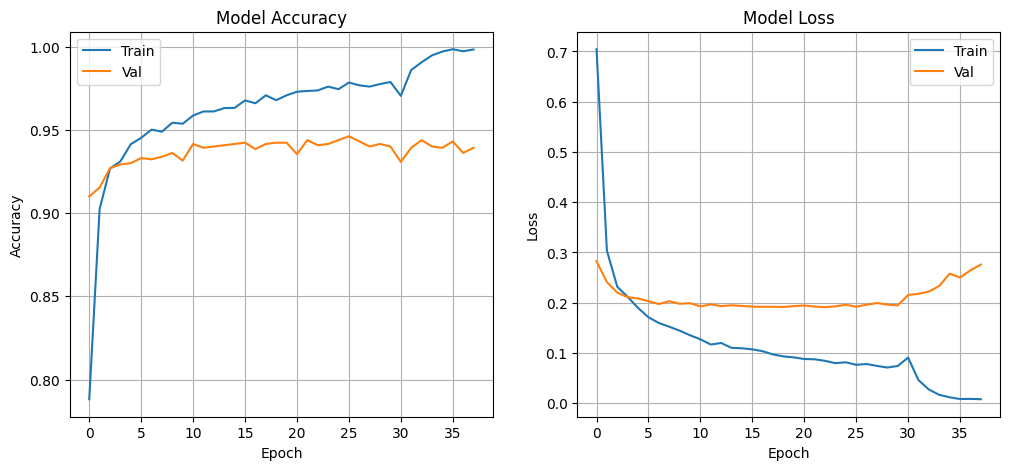

In [ ]:

# Train best model (Feature Extraction)
model = tuner.hypermodel.build(best_hp)

save_dir = '/content/drive/MyDrive/Mini Project/Dog Classification/Trained Model'
os.makedirs(save_dir, exist_ok=True)
best_model_path = os.path.join(save_dir, 'resnet50_tuned.keras')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("--- Starting Feature Extraction Phase ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks
)

# Fine-tuning: unfreeze top layers
model.load_weights(best_model_path)

# Unfreeze 30 layers (around block 4 of ResNet50)
for layer in model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

print("--- Starting Fine-Tuning Phase ---")
model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

print(f"✅ Best model saved to: {best_model_path}")


# Plot learning graph
acc = history.history['accuracy'] + history_ft.history['accuracy']
val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.grid()

plt.subplot(1,2,2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

##Try The Model

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from google.colab import files
from PIL import Image
from io import BytesIO

# Define Constants
# The dictionary mapping the directory ID (class label) to the readable breed name.
ID_TO_NAME_MAP = {
    'n02089867': 'Walker Hound',
    'n02091244': 'Ibizan Hound',
    'n02091831': 'Saluki',
    'n02099601': 'Golden Retriever',
    'n02101006': 'Gordon Setter',
    'n02105505': 'Komondor',
    'n02108089': 'Boxer',
    'n02108551': 'Tibetan Mastiff',
    'n02108915': 'French Bulldog',
    'n02110063': 'Alaskan Malamute',
    'n02110341': 'Dalmatian',
    'n02111277': 'Newfoundland',
    'n02113712': 'Miniature Poodle'
}

IMG_SIZE = (224, 224)

# Get the list of directory IDs in the same alphabetical order the model uses
MODEL_CLASS_IDS = sorted(ID_TO_NAME_MAP.keys())

save_dir = '/content/drive/MyDrive/Mini Project/Dog Classification/Trained Model'
best_model_path = os.path.join(save_dir, 'resnet50_tuned.keras')
try:
    loaded_model = load_model(best_model_path)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"Error: Could not load model from Drive. Make sure Drive is mounted and path is correct. {e}")

✅ Model loaded successfully.


In [3]:

# Preprocessing Function

def preprocess_uploaded_image(image_bytes):
    # Load the image from bytes using PIL (Pillow)
    img = Image.open(BytesIO(image_bytes)).resize(IMG_SIZE)

    # Convert to a numpy array
    img_array = tf.keras.utils.img_to_array(img)

    # Add a batch dimension (shape: (1, 224, 224, 3))
    img_array = np.expand_dims(img_array, axis=0)

    # Apply the critical ResNet50 preprocessing
    return preprocess_input(img_array)


In [6]:

# Upload and Predict

MIN_CONFIDENCE = 0.70

print("\nUpload a dog image to classify:")
uploaded = files.upload()

if uploaded:
    file_name = next(iter(uploaded))
    image_bytes = uploaded[file_name]

    # 1. Preprocess the image
    processed_image = preprocess_uploaded_image(image_bytes)

    # 2. Make the prediction
    predictions = loaded_model.predict(processed_image)

    # 3. Interpret the result
    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index] * 100

    if confidence >= MIN_CONFIDENCE * 100:
        predicted_id = MODEL_CLASS_IDS[predicted_index]
        predicted_breed_name = ID_TO_NAME_MAP.get(predicted_id, "UNKNOWN BREED")

        print("-" * 40)
        print(f" CLASSIFICATION RESULT ")
        print("-" * 40)
        print(f"Image File: {file_name}")
        print(f"Predicted Breed: {predicted_breed_name}")
        print(f"Confidence: {confidence:.2f}%")
        print("-" * 40)

    else:
        # Prediction is NOT confident enough
        print("-" * 40)
        print(f" CLASSIFICATION UNCERTAIN")
        print("-" * 40)
        print(f"Image File: {file_name}")
        print(f"Highest Confidence: {confidence:.2f}% (Below required threshold of {MIN_CONFIDENCE*100:.0f}%)")
        print("The model cannot confidently identify a dog breed from this image.")
        print("-" * 40)

else:
    print("No file was uploaded.")


Upload a dog image to classify:


Saving istockphoto-1313232209-612x612.jpg to istockphoto-1313232209-612x612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
----------------------------------------
 CLASSIFICATION UNCERTAIN
----------------------------------------
Image File: istockphoto-1313232209-612x612.jpg
Highest Confidence: 46.84% (Below required threshold of 70%)
The model cannot confidently identify a dog breed from this image.
----------------------------------------


##Implementation of RAG for dog information

###API KEY using Gemini

In [8]:
# API Key Setup (Using Colab Secrets)

import os
from google import genai
from google.colab import userdata

try:
    gemini_api_key = userdata.get('GEMINI_API_KEY')

    os.environ['GEMINI_API_KEY'] = gemini_api_key

    client = genai.Client(api_key=gemini_api_key)
    print("Gemini Client initialized successfully using Colab Secrets.")

except Exception as e:
    print("Error initializing Gemini Client.")
    print("Please ensure you have added a secret named 'GEMINI_API_KEY' in the Colab Secrets panel.")
    print(f"Error details: {e}")

Gemini Client initialized successfully using Colab Secrets.


###RAG

In [9]:
# SETUP AND INDEXING (RAG Retrieval Phase)

!pip install -q langchain pypdf sentence-transformers faiss-cpu langchain-community

import os
from google.colab import drive
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import SentenceTransformerEmbeddings

PDF_DIR = "/content/drive/MyDrive/Mini Project/Dog Classification/Dogs Information"
FAISS_INDEX_PATH = "/content/faiss_dog_index"

# 1. Load Documents
print("1. Loading documents from Drive...")
documents = []
if os.path.exists(PDF_DIR):
    for file_name in os.listdir(PDF_DIR):
        if file_name.endswith(".pdf"):
            file_path = os.path.join(PDF_DIR, file_name)
            # Use PyPDFLoader to extract text from the PDF
            loader = PyPDFLoader(file_path)
            documents.extend(loader.load())
else:
    raise FileNotFoundError(f"Directory not found: {PDF_DIR}. Check Drive path and mounting status.")

if not documents:
    raise ValueError(f"No PDF files found in {PDF_DIR}. Ensure files are present.")

# 2. Split Documents (Chunking)
print(f"2. Splitting {len(documents)} document pages into chunks...")
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
texts = text_splitter.split_documents(documents)
print(f"   -> Created {len(texts)} chunks.")

# 3. Create Embeddings
print("3. Creating embeddings (using CPU, may take a minute)...")
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# 4. Create and Save FAISS Vector Store
db = FAISS.from_documents(texts, embeddings)
db.save_local(FAISS_INDEX_PATH)
print(f"✅ RAG Index saved successfully to {FAISS_INDEX_PATH}.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
1. Loading documents from Drive...
2. Splitting 26 document pages into chunks...
   -> Created 69 chunks.
3. Creating embeddings (using CPU, may take a minute)...


/tmp/ipython-input-4285202569.py:42: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  w

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ RAG Index saved successfully to /content/faiss_dog_index.


In [12]:
# MODEL & FUNCTION SETUP

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image
from io import BytesIO
import textwrap

IMG_SIZE = (224, 224)
save_dir = '/content/drive/MyDrive/Mini Project/Dog Classification/Trained Model'
best_model_path = os.path.join(save_dir, 'resnet50_tuned.keras')

ID_TO_NAME_MAP = {
    'n02089867': 'Walker Hound', 'n02091244': 'Ibizan Hound', 'n02091831': 'Saluki',
    'n02099601': 'Golden Retriever', 'n02101006': 'Gordon Setter', 'n02105505': 'Komondor',
    'n02108089': 'Boxer', 'n02108551': 'Tibetan Mastiff', 'n02108915': 'French Bulldog',
    'n02110063': 'Alaskan Malamute', 'n02110341': 'Dalmatian', 'n02111277': 'Newfoundland',
    'n02113712': 'Miniature Poodle'
}
MODEL_CLASS_IDS = sorted(ID_TO_NAME_MAP.keys())


# 1. Load the Trained Keras Model
try:
    loaded_model = load_model(best_model_path)
    print("✅ Classification Model loaded.")
except Exception as e:
    print(f"❌ Error loading model: {e}")

# 2. RAG Setup (Load the Index)
FAISS_INDEX_PATH = "/content/faiss_dog_index"
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
try:
    retriever_db = FAISS.load_local(FAISS_INDEX_PATH, embeddings, allow_dangerous_deserialization=True)
    print("✅ RAG Index loaded.")
except Exception as e:
    print(f"❌ RAG Index not found. Did you run the Indexing cell first? {e}")


# 3. Preprocessing Function
def preprocess_uploaded_image(image_bytes):
    img = Image.open(BytesIO(image_bytes)).resize(IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)


# 4. RAG Retrieval/Generation Function
def retrieve_and_generate_summary(breed_name):
    # --- RAG Retrieval: Search the vector database ---
    query = f"Provide a detailed summary, history, and key care traits for the {breed_name}."
    docs = retriever_db.similarity_search(query, k=4)

    # 1. Augmentation: Combine retrieved context chunks into a single string
    context = "\n--- FACT CHUNK ---\n".join([doc.page_content for doc in docs])

    # 2. Augmentation: Create the Prompt
    system_prompt = (
        "You are a professional canine expert and breed analyst. "
        "Your task is to synthesize the provided facts into a concise, well-structured "
        "summary of the dog breed. ONLY use the information given in the 'CONTEXT' section below. "
        "Do not invent new information."
    )

    # 3. Augmentation: Create the Final User Prompt
    user_prompt = f"""
    Based ONLY on the CONTEXT provided below, write a comprehensive summary for the {breed_name}.
    The summary must cover Origin/History, Key Traits, and Health/Care needs.

    CONTEXT:
    ---
    {context}
    ---
    """

    # 4. Generation: Call the Gemini API
    try:
        response = client.models.generate_content(
            model='gemini-2.5-flash',
            contents=user_prompt,
            config=genai.types.GenerateContentConfig(
                system_instruction=system_prompt,
                temperature=0.2
            )
        )

        summary = response.text

        print(f"✅ LLM Summary Generated.")
        return f"\n INFORMATION for {breed_name} \n" + "-"*45 + f"\n{summary}\n" + "-"*45

    except Exception as e:
        return f"❌ Error during Gemini API call: {e}. Cannot generate summary."

✅ Classification Model loaded.
✅ RAG Index loaded.


In [13]:
# EXECUTE PREDICTION AND RAG

from google.colab import files

MIN_CONFIDENCE = 0.70

print("\nUpload a dog image to classify:")
uploaded = files.upload()

if uploaded:
    file_name = next(iter(uploaded))
    image_bytes = uploaded[file_name]

    # 1. Image Classification
    processed_image = preprocess_uploaded_image(image_bytes)
    predictions = loaded_model.predict(processed_image)

    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index] * 100

    # 2. Confidence Check
    if confidence >= MIN_CONFIDENCE * 100:
        predicted_id = MODEL_CLASS_IDS[predicted_index]
        predicted_breed_name = ID_TO_NAME_MAP.get(predicted_id, "UNKNOWN BREED")

        print("-" * 40)
        print(f"CLASSIFICATION RESULT")
        print("-" * 40)
        print(f"Image File: {file_name}")
        print(f"Predicted Breed: {predicted_breed_name}")
        print(f"Confidence: {confidence:.2f}%")
        print("-" * 40)

        # 3. RAG Execution (Only runs if confident)
        rag_output = retrieve_and_generate_summary(predicted_breed_name)
        print(rag_output)

    else:
        print("-" * 40)
        print(f"CLASSIFICATION UNCERTAIN")
        print("-" * 40)
        print(f"Image File: {file_name}")
        print(f"Highest Confidence: {confidence:.2f}% (Below required threshold of {MIN_CONFIDENCE*100:.0f}%)")
        print("The model cannot confidently identify a dog breed from this image. RAG retrieval skipped.")
        print("-" * 40)

else:
    print("No file was uploaded. Please try again.")


Upload a dog image to classify:


Saving anjing-alaskan-malamute_ratio-16x9.jpg to anjing-alaskan-malamute_ratio-16x9 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
----------------------------------------
CLASSIFICATION RESULT
----------------------------------------
Image File: anjing-alaskan-malamute_ratio-16x9 (3).jpg
Predicted Breed: Alaskan Malamute
Confidence: 99.85%
----------------------------------------
✅ LLM Summary Generated.

 INFORMATION for Alaskan Malamute 
---------------------------------------------
The Alaskan Malamute is one of the oldest and largest Arctic sled dog breeds, originating in the coastal regions of Alaska. Developed by the Mahlemut Inuit tribe, from whom it takes its name, the breed was essential for their survival. Its original purpose was to haul heavy freight long distances at a slow, steady pace, and to hunt seals and bears, being bred for strength and endurance rather than speed. Today, Malamutes are popular family companions and participate in weight pulling, sledding, and hiking e

##GitHub shows “Invalid Notebook” because Colab adds extra widget metadata that GitHub can’t read, so we remove that metadata to make the notebook viewable.

In [16]:
from google.colab import files
uploaded = files.upload()  # choose your downloaded .ipynb file


Saving Dog_Breed_Classification_with_information_using_RAG.ipynb to Dog_Breed_Classification_with_information_using_RAG.ipynb


In [17]:
import nbformat

path = "Dog_Breed_Classification_with_information_using_RAG.ipynb"  # must match your uploaded file name
nb = nbformat.read(path, as_version=4)

if 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

nbformat.write(nb, path)
print("Cleaned notebook metadata ✅")


Cleaned notebook metadata ✅


In [19]:
from google.colab import files
files.download(path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>